<a href="https://colab.research.google.com/github/rubanasyeda/LSi-Team-Vision/blob/main/analyser/random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
from google.colab import files
uploaded = files.upload()




Saving toronto-weather-2023.csv to toronto-weather-2023.csv
Saving toronto-weather-2024.csv to toronto-weather-2024.csv
Saving toronto-weather-2025.csv to toronto-weather-2025.csv
Saving toronto-weather-2021.csv to toronto-weather-2021 (1).csv
Saving toronto-weather-2022.csv to toronto-weather-2022.csv


## 1. Load & Concatenate All Occupancy Files


In [25]:
import glob
import pandas as pd
import numpy as np
import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import matplotlib.pyplot as plt

# fix the typo in the 2022 filename
import os
if os.path.exists('toronto-occupany-2022.csv'):
    os.rename('toronto-occupany-2022.csv', 'toronto-occupancy-2022.csv')

# gather all 5 years
files = sorted(glob.glob('toronto-occupancy-*.csv'))


In [26]:
weather_files = sorted(glob.glob('toronto-weather-202*.csv'))

weather_list = []
for file in weather_files:
    df_weather = pd.read_csv(file)

    # Standardize date column
    df_weather['OCCUPANCY_DATE'] = pd.to_datetime(df_weather['Date/Time'], format='%Y-%m-%d', errors='coerce')

    # Keep only relevant weather features (add more if you want!)
    df_weather = df_weather[['OCCUPANCY_DATE', 'Max Temp (°C)', 'Min Temp (°C)', 'Total Precip (mm)', 'Snow on Grnd (cm)']]
    weather_list.append(df_weather)

# Combine into one DataFrame
weather_df = pd.concat(weather_list, ignore_index=True).dropna()
print(" Weather data shape:", weather_df.shape)


 Weather data shape: (520, 5)


In [50]:
data_2021 = pd.read_csv('toronto-occupancy-2021.csv')
data_2022 = pd.read_csv('toronto-occupancy-2022.csv')
data_2023 = pd.read_csv('toronto-occupancy-2023.csv')
data_2024 = pd.read_csv('toronto-occupancy-2024.csv')
data_2025 = pd.read_csv('toronto-occupancy-2025.csv')
data_weather_2021 = pd.read_csv('toronto-weather-2021.csv')
data_weather_2022 = pd.read_csv('toronto-weather-2022.csv')
data_weather_2023 = pd.read_csv('toronto-weather-2023.csv')
data_weather_2024 = pd.read_csv('toronto-weather-2024.csv')
data_weather_2025 = pd.read_csv('toronto-weather-2025.csv')

# Rename to standardize and remove any weird characters
weather_data.columns = weather_data.columns.str.strip().str.replace('Â', '').str.replace('\ufeff', '')

# Just to be 100% sure
weather_data = weather_data.rename(columns={'Date/Time': 'OCCUPANCY_DATE'})

# Confirm column is still there
print(weather_data.columns.tolist())

df = df.merge(weather_data, on='OCCUPANCY_DATE', how='left')
df = df.sort_values('OCCUPANCY_DATE')
df = df.fillna(method='ffill')  # forward fill any missing weather info

# Check again
print('Snow on Grnd (cm)' in df.columns)



['OCCUPANCY_DATE', 'Max Temp (°C)', 'Min Temp (°C)', 'Total Precip (mm)', 'Snow on Grnd (cm)']
True


<ipython-input-50-fa033bb06f86>:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')  # forward fill any missing weather info


In [51]:
# Keep relevant columns
occupancy_data = pd.concat([
    data_2021[['OCCUPANCY_DATE', 'PROGRAM_ID', 'OCCUPANCY_RATE_BEDS']],
    data_2022[['OCCUPANCY_DATE', 'PROGRAM_ID', 'OCCUPANCY_RATE_BEDS']],
    data_2023[['OCCUPANCY_DATE', 'PROGRAM_ID', 'OCCUPANCY_RATE_BEDS']],
    data_2024[['OCCUPANCY_DATE', 'PROGRAM_ID', 'OCCUPANCY_RATE_BEDS']],
    data_2025[['OCCUPANCY_DATE', 'PROGRAM_ID', 'OCCUPANCY_RATE_BEDS']],
], ignore_index=True)

# Parse dates
occupancy_data['OCCUPANCY_DATE'] = pd.to_datetime(occupancy_data['OCCUPANCY_DATE'], errors='coerce')
occupancy_data = occupancy_data.dropna(subset=['OCCUPANCY_DATE', 'PROGRAM_ID', 'OCCUPANCY_RATE_BEDS'])


<ipython-input-51-4b291278fa79>:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  occupancy_data['OCCUPANCY_DATE'] = pd.to_datetime(occupancy_data['OCCUPANCY_DATE'], errors='coerce')


In [52]:
# Add all together
all_data = pd.concat([data_2021, data_2022, data_2023, data_2024, data_2025], ignore_index=True)

# Parse OCCUPANCY_DATE safely
all_data['OCCUPANCY_DATE'] = pd.to_datetime(all_data['OCCUPANCY_DATE'], format='%Y-%m-%d', errors='coerce')

# Drop any invalid or missing data
all_data = all_data.dropna(subset=['OCCUPANCY_DATE', 'PROGRAM_ID', 'OCCUPANCY_RATE_BEDS'])

# Keep only needed columns
df = all_data[['OCCUPANCY_DATE', 'PROGRAM_ID', 'OCCUPANCY_RATE_BEDS']].copy()

print(" Combined & cleaned shape:", df.shape)
df.head()





 Combined & cleaned shape: (44899, 3)


,OCCUPANCY_DATE,PROGRAM_ID,OCCUPANCY_RATE_BEDS
148769,2024-01-01,12251,100.00
148774,2024-01-01,12011,100.00
148775,2024-01-01,13611,100.00
148776,2024-01-01,17891,82.61
148779,2024-01-01,17931,43.75


In [61]:
results = test_df[['OCCUPANCY_DATE', 'PROGRAM_ID']].copy()
results['Actual'] = y_test.values
results['Predicted'] = y_pred
results['Error'] = results['Actual'] - results['Predicted']
results['Absolute_Error'] = results['Error'].abs()

results.head(10)


,OCCUPANCY_DATE,PROGRAM_ID,Actual,Predicted,Error,Absolute_Error
127957,2025-01-01,14951,100.00,100.000000,0.000000,0.000000
127958,2025-01-01,11931,100.00,100.000000,0.000000,0.000000
127959,2025-01-01,12252,100.00,100.000000,0.000000,0.000000
127960,2025-01-01,12253,100.00,100.000000,0.000000,0.000000
127961,2025-01-01,13331,97.30,96.988366,0.311634,0.311634
127962,2025-01-01,13191,92.31,92.321644,-0.011644,0.011644
127963,2025-01-01,16391,100.00,100.000000,0.000000,0.000000
127964,2025-01-01,12256,100.00,100.000000,0.000000,0.000000
127965,2025-01-01,12254,100.00,100.000000,0.000000,0.000000
127966,2025-01-01,14931,98.57,98.573315,-0.003315,0.003315


In [53]:
weather_data = pd.concat([
    data_weather_2021,
    data_weather_2022,
    data_weather_2023,
    data_weather_2024,
    data_weather_2025
], ignore_index=True)

# Standardize weather column names
weather_data['OCCUPANCY_DATE'] = pd.to_datetime(weather_data['Date/Time'], errors='coerce')

weather_data = weather_data[[
    'OCCUPANCY_DATE',
    'Max Temp (°C)',
    'Min Temp (°C)',
    'Total Precip (mm)',
    'Snow on Grnd (cm)'
]]

weather_data = weather_data.dropna()


In [54]:
df = occupancy_data.merge(weather_data, on='OCCUPANCY_DATE', how='left')
df = df.sort_values('OCCUPANCY_DATE')
df = df.fillna(method='ffill')  # fill any missing weather data


<ipython-input-54-975f4e580190>:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')  # fill any missing weather data


In [55]:
# Add time features
df['year'] = df['OCCUPANCY_DATE'].dt.year
df['month'] = df['OCCUPANCY_DATE'].dt.month
df['day'] = df['OCCUPANCY_DATE'].dt.day
df['weekday'] = df['OCCUPANCY_DATE'].dt.weekday

# Add lag feature
df['PREV_DATE'] = df['OCCUPANCY_DATE'] - pd.Timedelta(days=1)
prev = df[['PREV_DATE', 'PROGRAM_ID', 'OCCUPANCY_RATE_BEDS']].copy()
prev = prev.rename(columns={'OCCUPANCY_RATE_BEDS': 'PREV_RATE'})

df = df.merge(prev, how='left', on=['PREV_DATE', 'PROGRAM_ID'])
df = df.dropna()


In [56]:
train_df = df[df['year'] < 2025]
test_df = df[df['year'] == 2025]

X_train = train_df.drop(columns=['OCCUPANCY_DATE', 'PREV_DATE', 'OCCUPANCY_RATE_BEDS'])
y_train = train_df['OCCUPANCY_RATE_BEDS']

X_test = test_df.drop(columns=['OCCUPANCY_DATE', 'PREV_DATE', 'OCCUPANCY_RATE_BEDS'])
y_test = test_df['OCCUPANCY_RATE_BEDS']

rf = RandomForestRegressor(n_estimators=300, max_depth=15, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

rmse = sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f" Test Year 2025 — RMSE: {rmse:.2f}, MAE: {mae:.2f}")


 Test Year 2025 — RMSE: 2.87, MAE: 0.82


<ipython-input-59-1ddaac93546f>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  snow_impact = df.groupby('Snow_Category')['OCCUPANCY_RATE_BEDS'].mean().reset_index()
<ipython-input-59-1ddaac93546f>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=snow_impact, x='Snow_Category', y='OCCUPANCY_RATE_BEDS', palette='Blues')


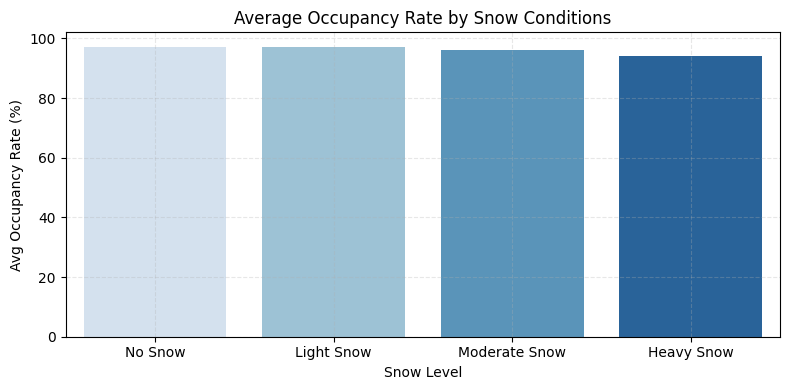

In [59]:
df['Snow_Category'] = pd.cut(df['Snow on Grnd (cm)'], bins=[-1, 0, 5, 20, 100],
                             labels=['No Snow', 'Light Snow', 'Moderate Snow', 'Heavy Snow'])

snow_impact = df.groupby('Snow_Category')['OCCUPANCY_RATE_BEDS'].mean().reset_index()


plt.figure(figsize=(8, 4))
sns.barplot(data=snow_impact, x='Snow_Category', y='OCCUPANCY_RATE_BEDS', palette='Blues')
plt.title('Average Occupancy Rate by Snow Conditions')
plt.ylabel('Avg Occupancy Rate (%)')
plt.xlabel('Snow Level')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


In [64]:
# --- 1) Load occupancy data (2021–2025) ---
occ_files = sorted(glob.glob('toronto-occupancy-*.csv'))
occ_list = []
for fn in occ_files:
    df_occ = pd.read_csv(fn, parse_dates=['OCCUPANCY_DATE'], low_memory=False)
    occ_list.append(df_occ[['OCCUPANCY_DATE','PROGRAM_ID','OCCUPANCY_RATE_BEDS']])
occupancy = pd.concat(occ_list, ignore_index=True)

# --- 2) Load weather data (2021–2025) ---
weather_files = sorted(glob.glob('toronto-weather-*.csv'))
weather_list = []
for fn in weather_files:
    df_w = pd.read_csv(fn)
    df_w['OCCUPANCY_DATE'] = pd.to_datetime(df_w['Date/Time'], errors='coerce')
    weather_list.append(df_w[['OCCUPANCY_DATE',
                              'Max Temp (°C)',
                              'Min Temp (°C)',
                              'Total Precip (mm)',
                              'Snow on Grnd (cm)']])
weather = pd.concat(weather_list, ignore_index=True)

# --- 3) Merge occupancy + weather on date ---
df = pd.merge(occupancy, weather, on='OCCUPANCY_DATE', how='left')
df = df.sort_values('OCCUPANCY_DATE').fillna(method='ffill')

# --- 4) Final inspection table ---
final_table = df[[
    'OCCUPANCY_DATE','PROGRAM_ID','OCCUPANCY_RATE_BEDS',
    'Max Temp (°C)','Min Temp (°C)','Total Precip (mm)','Snow on Grnd (cm)'
]].reset_index(drop=True)
print("=== Final Occupancy & Weather Table (first 10 rows) ===")
print(final_table.head(10).to_string(index=False))


<ipython-input-64-5e7e6e479e49>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_occ = pd.read_csv(fn, parse_dates=['OCCUPANCY_DATE'], low_memory=False)
<ipython-input-64-5e7e6e479e49>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_occ = pd.read_csv(fn, parse_dates=['OCCUPANCY_DATE'], low_memory=False)


=== Final Occupancy & Weather Table (first 10 rows) ===
OCCUPANCY_DATE  PROGRAM_ID  OCCUPANCY_RATE_BEDS  Max Temp (°C)  Min Temp (°C)  Total Precip (mm)  Snow on Grnd (cm)
    2001-01-21       15371                  NaN            NaN            NaN                NaN                NaN
    2001-01-21       15071               100.00            NaN            NaN                NaN                NaN
    2001-01-21       12111                96.15            NaN            NaN                NaN                NaN
    2001-01-21       12211               100.00            NaN            NaN                NaN                NaN
    2001-01-21       12231               100.00            NaN            NaN                NaN                NaN
    2001-01-21       12232                83.33            NaN            NaN                NaN                NaN
    2001-01-21       15611                83.33            NaN            NaN                NaN                NaN
    2001-01-21  

<ipython-input-64-5e7e6e479e49>:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.sort_values('OCCUPANCY_DATE').fillna(method='ffill')


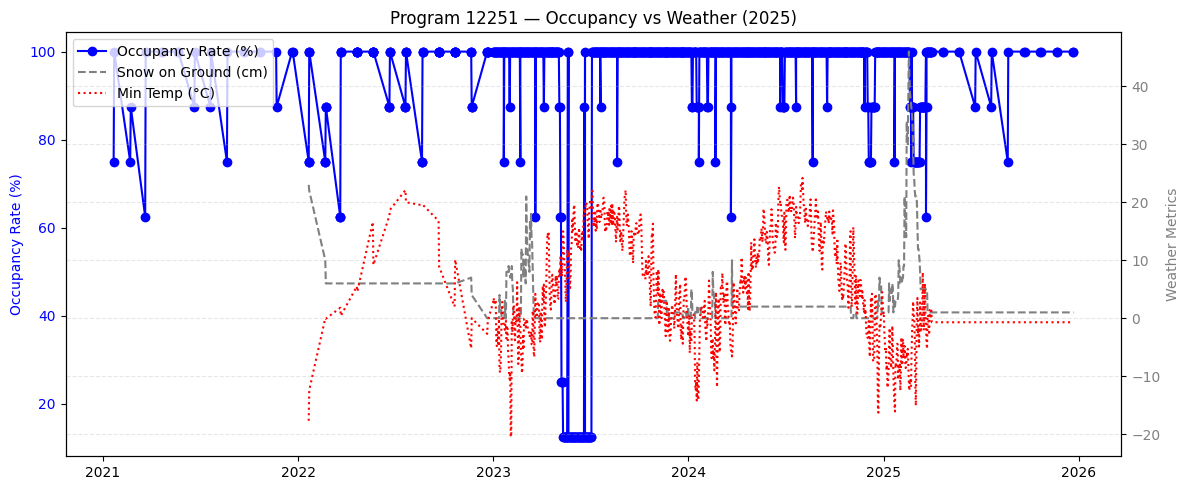

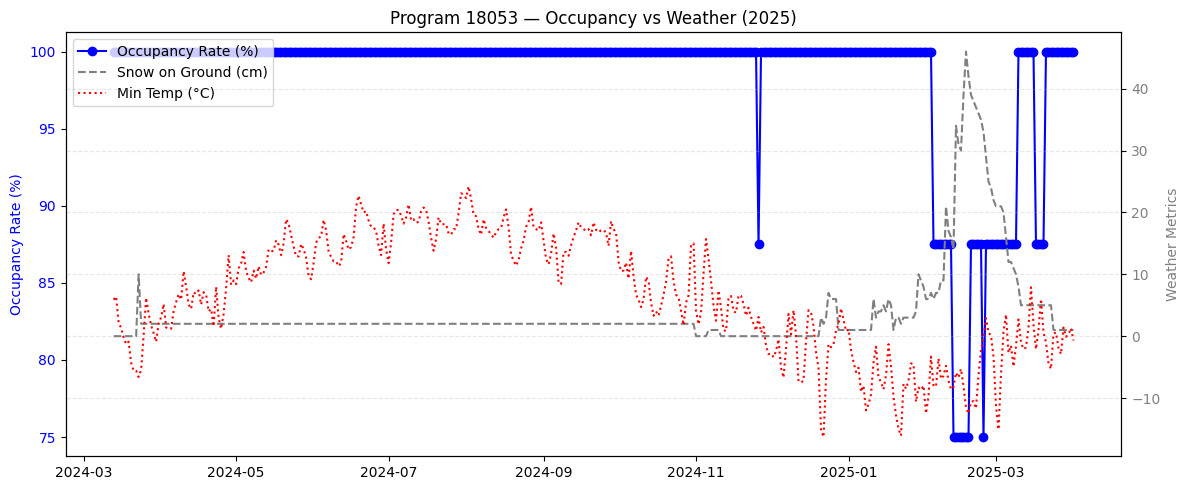

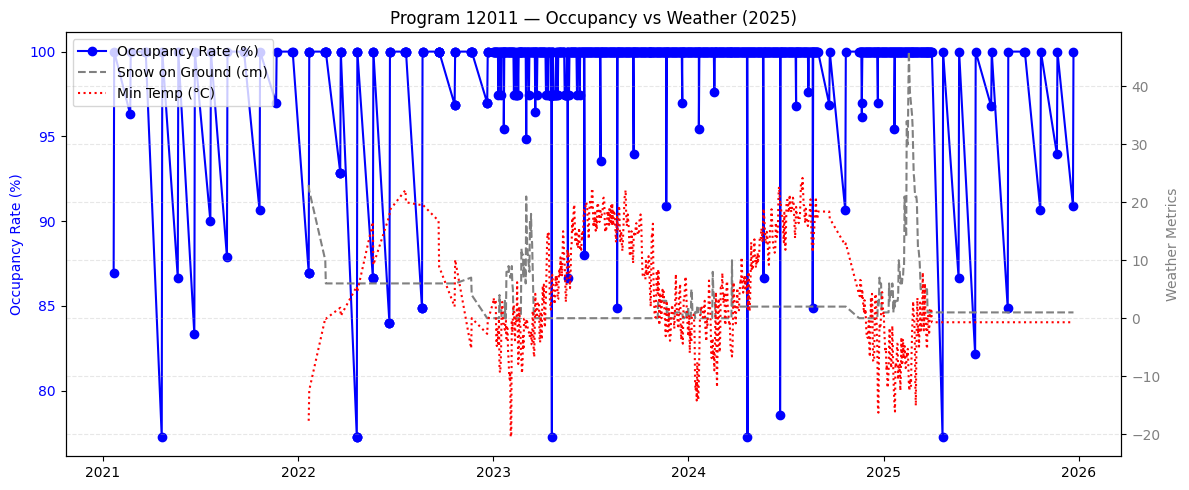

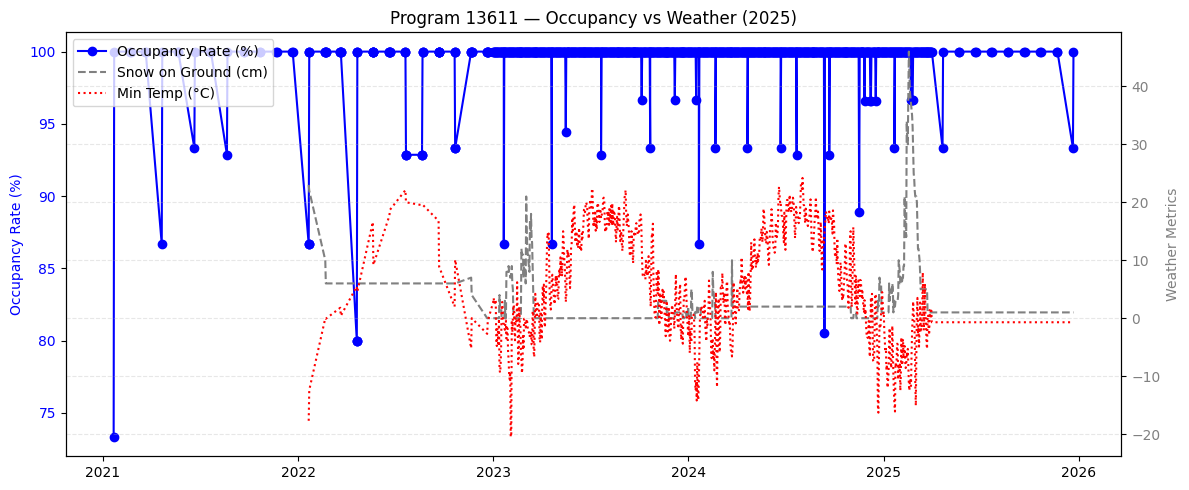

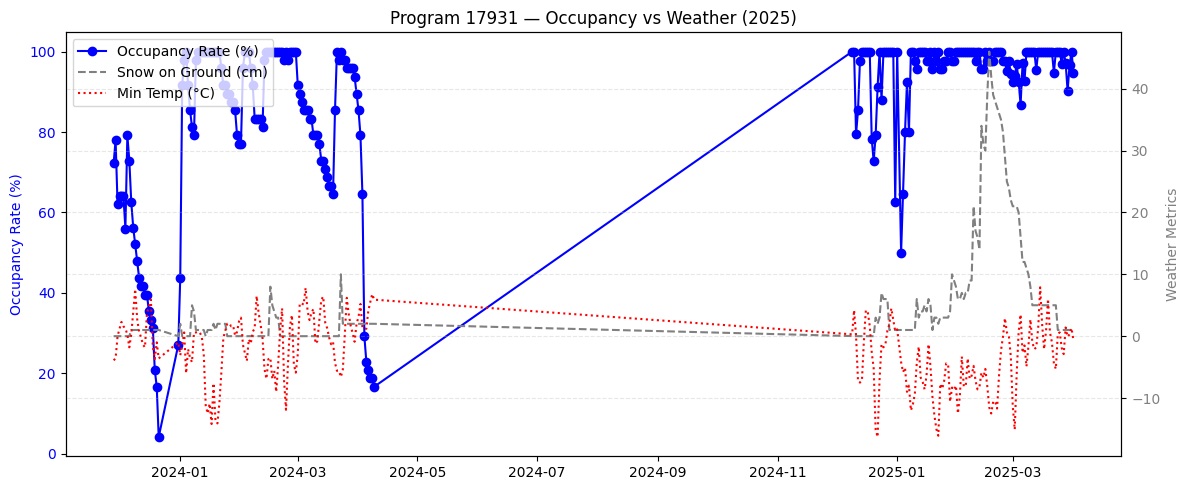

In [69]:
# List of shelter program IDs you want to plot
program_ids = [12251, 18053, 12011, 13611, 17931]  # You can change/add more IDs

for program_id in program_ids:
    shelter_df = df[df['PROGRAM_ID'] == program_id].copy()
    shelter_df = shelter_df.sort_values('OCCUPANCY_DATE')

    # Optional: limit to 2021–2025
    shelter_df = shelter_df[
        (shelter_df['OCCUPANCY_DATE'] >= '2021-01-01') &
        (shelter_df['OCCUPANCY_DATE'] <= '2025-12-31')
    ]

    # Plot: Occupancy Rate vs Snow + Temperature
    fig, ax1 = plt.subplots(figsize=(12, 5))

    ax1.plot(shelter_df['OCCUPANCY_DATE'], shelter_df['OCCUPANCY_RATE_BEDS'],
             label='Occupancy Rate (%)', color='blue', marker='o')
    ax1.set_ylabel('Occupancy Rate (%)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Add snow and temp on secondary y-axis
    ax2 = ax1.twinx()
    ax2.plot(shelter_df['OCCUPANCY_DATE'], shelter_df['Snow on Grnd (cm)'],
             label='Snow on Ground (cm)', color='gray', linestyle='--')
    ax2.plot(shelter_df['OCCUPANCY_DATE'], shelter_df['Min Temp (°C)'],
             label='Min Temp (°C)', color='red', linestyle=':')
    ax2.set_ylabel('Weather Metrics', color='gray')
    ax2.tick_params(axis='y', labelcolor='gray')

    # Combine legends
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='upper left')

    plt.title(f'Program {program_id} — Occupancy vs Weather (2025)')
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()
